
see 
https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [3]:
import pandas as pd
import numpy as np
import csv
import glob
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
"""
ok things to have..
code? 
type of element?
origin?
index is ideally unique.
"""
def read_csv_file(filename):
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        data = {}
        file = filename.split("/")[-1]
        method = file[:4]
        itembigname = file.split(" ")[0]
        item = itembigname.split("_",1)[-1]
        data["method"] = method
        data["item"] = item
        next(reader) # skip header
        for row in reader:
            element = row[0]
            line = row[1]
            elementname = f"{element}_{line}"
            area = row[4]
            data[elementname] = int(area)
    return data

In [5]:
def find_all_data_files(folder="../results"):
    return [x.replace("\\","/") for x in glob.glob(f"{folder}/*.csv")]

In [6]:
raw_data = []
for filename in find_all_data_files():
    raw_data.append(read_csv_file(filename))

In [7]:
df = pd.DataFrame(raw_data)

In [8]:
df_nocal = df[df['item'] != "Mn"]
element_columns = [col for col in df_nocal.columns if col not in ["method", "item"]]

In [9]:
wanted_elements = ["Fe", "Rb", "Sr", "Y", "Zr", "Nb", "Mn"] # "Th" dropped

In [10]:
def standardize_columns(df_, columns):
    """transform mean = 0 and variance = 1, assumes gaussian distribution of columns"""
    df = df_.copy()
    # Separating out the features
    x = df.loc[:, columns].values# Separating out the target
    # y = df.loc[:,['target']].values# Standardizing the features 
    x = StandardScaler().fit_transform(x)
    df.loc[:, columns] = x
    df['method'] = df_['method']
    df['item'] = df_['item']
    return df

In [11]:
def pca(df_, columns, n_components=None):
    pca_ = PCA(n_components=n_components)
    x = df_.loc[:, columns].values
    pca_.fit(x)
    df = pd.DataFrame(pca_.transform(x))
    df['method'] = df_['method']
    df['item'] = df_['item']
    # df = df.append(df_[['method', 'item']])
    return {"transformed":df, "model": pca_}

In [12]:
def explain_model(model: PCA):
    pc1, pc2 = model.components_
    print("components:\n", "pc1:", pc1, "\n", "pc2:", pc2)
    print("explained variance ratio:\n", model.explained_variance_ratio_)
    print("total variance in columns:", f"{sum(model.explained_variance_ratio_)*100:.2f}%")
    
def reverse_pca(result_dict):
    d = result_dict
    data = d['transformed'].copy()
    return d['model'].inverse_transform(data)

In [23]:
def make_pca_and_plot(data, method, wanted_elements, filename=None):
    if wanted_elements is None:
        wanted_elements = ["Fe", "Rb", "Sr", "Y", "Zr", "Nb", "Mn"] # "Th" dropped
    element_columns = [col for col in data.columns if col not in ["method", "item"]]
    
    # filtrer ut andre elementer
    to_drop = []
    for col in element_columns:
        elm = col.split("_")[0]
        if elm not in wanted_elements:
            to_drop.append(col)
    df = data.drop(columns=to_drop).query(f"method == '{method}'").reset_index(drop=True)
    
    print("df:\n", df.head())
    
    # standariser colonnene
    element_in_columns_ds = [col for col in df.columns if col not in ["method", "item"]]
    std_data = standardize_columns(df, element_in_columns_ds)
    
    print("standardized:\n",std_data.head())
    
    # kjør pca
    d = pca(std_data, element_in_columns_ds, n_components=2)
    
    explain_model(d['model'])
    
    print("importance of elements")
    pca1, pca2 = d['model'].components_
    importance_dict = {"element":element_in_columns_ds, "component_1": pca1, "component_2": pca2}
    importance_table = pd.DataFrame(importance_dict)
    importance_table['product'] = np.abs(importance_table['component_1'] * importance_table['component_2'])
    print(importance_table.sort_values(by=['product'], ascending=False))
    
    # plot data
    finalDf = d['transformed']
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    plt.figtext(.5,0,", ".join([method] + element_in_columns_ds), fontsize=18, ha='center')
    targets = list(set(finalDf['item']))

    sns.reset_orig() # get original matplotlib colors
    clrs = sns.color_palette("cubehelix", n_colors=len(targets))


    for i, target in enumerate(targets):
        indicesToKeep = finalDf['item'] == target
        lines = ax.scatter(finalDf.loc[indicesToKeep, 0]
                   , finalDf.loc[indicesToKeep, 1]
                   , s = 30)
        lines.set_color(clrs[i])
    ax.legend(targets)
    ax.grid()
    if filename:
        plt.savefig(filename)


In [20]:
df_nocal.columns

Index(['method', 'item', 'Na_K12', 'Mg_K12', 'Al_K12', 'Si_K12', 'S_K12',
       'Cl_K12', 'K_K12', 'Ca_K12', 'Ti_K12', 'V_K12', 'Cr_K12', 'Mn_K12',
       'Fe_K12', 'Co_K12', 'Ni_K12', 'Cu_K12', 'Zn_K12', 'Ga_K12', 'Ge_K12',
       'As_K12', 'Se_K12', 'Br_K12', 'Rb_K12', 'Sr_K12', 'Y_K12', 'Zr_K12',
       'Nb_K12', 'Rh_K12', 'Rh_L1', 'Pd_K12', 'Pd_L1', 'Ag_K12', 'Ag_L1',
       'Cd_K12', 'Cd_L1', 'Sn_K12', 'Sn_L1', 'Sb_K12', 'Sb_L1', 'Os_L1',
       'Os_M1', 'Au_L1', 'Au_M1', 'Hg_L1', 'Hg_M1', 'Pb_L1', 'Pb_M1', 'Bi_L1',
       'Bi_M1', 'Th_L1', 'Th_M1', 'U_L1', 'U_M1'],
      dtype='object')

In [15]:
df_nocal.query("item == '0001_57_276_1' and method == 'kee1'")

,method,item,Na_K12,Mg_K12,Al_K12,Si_K12,S_K12,Cl_K12,K_K12,Ca_K12,...,Hg_L1,Hg_M1,Pb_L1,Pb_M1,Bi_L1,Bi_M1,Th_L1,Th_M1,U_L1,U_M1
34,kee1,0001_57_276_1,9545,1468,12023,93756,1081,45001,28553,97527,...,8312,598,5118,0,913,0,25373,0,18619,108790
35,kee1,0001_57_276_1,4487,452,4266,38644,1424,21705,16052,47876,...,3915,0,2907,0,211,0,13184,0,10306,46126
36,kee1,0001_57_276_1,5246,586,4464,39150,1845,3607,99178,171450,...,3420,0,1969,0,909,0,30598,0,1760,264
37,kee1,0001_57_276_1,4695,554,4989,38543,1400,19661,10332,40744,...,4496,12,3205,0,633,0,12819,0,8694,47779


df:
   method        item  Na_K12  Ni_K12  Y_K12  Zr_K12  Pd_K12  Pd_L1  Cd_K12  \
0   kee1  0000_55506    7410   57611      0    2087   32131  19589      79   
1   kee1  0000_55506    7087   53532      0     319   32767  15797     151   
2   kee1  0000_55506    7013   54398    952    1271   31754  20014      74   
3   kee1  0000_55506    7407   58073    663       0   32201  17923     510   
4   kee1  0000_55506    6250   44619    675    1060   27868  19619     156   

   Cd_L1  
0      0  
1      0  
2      0  
3      0  
4      0  
standardized:
   method        item    Na_K12    Ni_K12     Y_K12    Zr_K12    Pd_K12  \
0   kee1  0000_55506  1.299440  2.465913 -0.473483 -0.709212  0.783553   
1   kee1  0000_55506  1.136753  2.192264 -0.473483 -0.933952  0.834751   
2   kee1  0000_55506  1.099481  2.250362 -0.001744 -0.812938  0.753205   
3   kee1  0000_55506  1.297929  2.496908 -0.144950 -0.974502  0.789188   
4   kee1  0000_55506  0.715179  1.594315 -0.139004 -0.839760  0.440386   



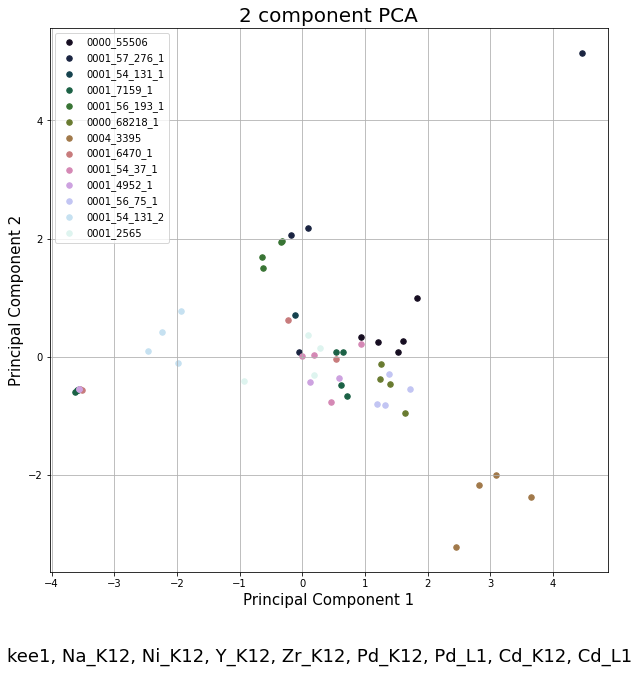

In [25]:
make_pca_and_plot(data=df_nocal, method="kee1", wanted_elements=['Ni', 'Cd', 'Pd', 'Na', 'Zr', 'Y'])

In [18]:
all_elements = list(set([col.split("_")[0] for col in df_nocal.columns if col not in ["method", "item"]]))

In [19]:
def get_importance_of_combination(data, method, wanted_elements, filename=None):
    element_columns = [col for col in data.columns if col not in ["method", "item"]]
    
    to_drop = []
    for col in element_columns:
        elm = col.split("_")[0]
        if elm not in wanted_elements:
            to_drop.append(col)
            
    df = data.drop(columns=to_drop).query(f"method == '{method}'").reset_index(drop=True)
    
    element_in_columns_ds = [col for col in df.columns if col not in ["method", "item"]]
    std_data = standardize_columns(df, element_in_columns_ds)
    
    d = pca(std_data, element_in_columns_ds, n_components=2)
    
    return wanted_elements, sum(d['model'].explained_variance_ratio_)

really we want decent clustering, and good separation between the different clusters. 

In [ ]:
from itertools import combinations

In [ ]:
import time

In [ ]:
from tqdm.notebook import tqdm, trange

In [ ]:
#results = {}

In [ ]:
"""
t0 = time.monotonic()
print("t0", t0)
for comb in tqdm(combinations(all_elements, 6)):
    results[comb] = get_importance_of_combination(data=df_nocal, method="kee1", wanted_elements=comb)
t1 = time.monotonic()
print("DONE!", "duration:", t1-t0)"""

In [ ]:
"""
with open("kee1_combos.txt", 'w') as f:
    f.write(str(results))
"""

In [ ]:
with open("kee1_combos.txt", 'r') as f:
    bigstr=f.read()

In [ ]:
"""
#super slowwww
import ast
results = ast.literal_eval(bigstr)"""

In [ ]:
bigstr[0:1000]

In [6]:
import re

[<re.Match object; span=(40, 97), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Au'), 0.708799147>,
 <re.Match object; span=(138, 195), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Fe'), 0.639220124>,
 <re.Match object; span=(236, 293), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Cd'), 0.644729677>,
 <re.Match object; span=(334, 391), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Co'), 0.690757458>,
 <re.Match object; span=(432, 489), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Ag'), 0.683982051>,
 <re.Match object; span=(530, 587), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Cr'), 0.624261908>,
 <re.Match object; span=(628, 685), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Mn'), 0.615294252>,
 <re.Match object; span=(726, 783), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Cl'), 0.671254117>,
 <re.Match object; span=(824, 881), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Si'), 0.710530642>,
 <re.Match object; span=(922, 979), match="('Ni', 'Ti', 'Ge', 'Se', 'Mg', 'Pd'), 0.699056404>]

In [17]:
bigdata = {}
it = re.finditer(r"\((?P<elements>('[A-z]+'(,?\s?)){6})\),(?P<val>\s\d+.\d+)\)", bigstr)
for match in it:
    bigdata[match.group("elements")] = float(match.group("val").strip())

In [60]:
combodf = pd.Series(bigdata)
combodf = combodf.sort_values()

In [61]:
cdf = pd.DataFrame(combodf)

In [82]:
combodf[combodf.between(0.60,0.80)].sample(10)

'Ni', 'Cd', 'Pd', 'Na', 'Zr', 'Y'     0.774765
'Au', 'Si', 'Sn', 'Rb', 'Y', 'As'     0.605697
'K', 'Sr', 'Pb', 'Rh', 'Bi', 'As'     0.713860
'Ni', 'Cd', 'Co', 'Si', 'Rb', 'V'     0.717758
'Ti', 'Ge', 'Cd', 'Si', 'Na', 'Ca'    0.665066
'Au', 'Co', 'Ag', 'Ga', 'U', 'Sn'     0.663245
'Ti', 'Mn', 'S', 'Sr', 'Zn', 'Hg'     0.614719
'Ni', 'Fe', 'Ag', 'Si', 'Rb', 'Hg'    0.632526
'Si', 'Nb', 'Na', 'Th', 'Ca', 'Bi'    0.601159
'Se', 'S', 'Sr', 'V', 'Zr', 'Y'       0.621888
dtype: float64